![](cover.png)
# TODO ADD COVER IMAGE

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
import math
from PIL import Image as PIL_Image
from tqdm import tqdm, trange

## Transformer-based caption generation
<hr>

**Caption generation** is the automated process of creating precise, grammatically sound descriptions for images. It requires recognizing essential objects, actions, and contextual elements within an image, then articulating them in natural language. This task bridges the fields of computer vision and natural language processing, leveraging a vision model to analyze image features and a language model to craft meaningful descriptive text.

The diagram provides a high-level overview: a pre-trained computer vision model (such as a CNN) first extracts image features, which are then fed into a language model to generate captions sequentially, word by word.

![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-1.png "Captioning")  
[source](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-1.png)
<br><br>

**Tools we will use:**

- `PyTorch` 
- [Hugging Face Transformers](https://huggingface.co/)
- [Pre-trained CNN models]()

The image captioning task consists of several key components, which we will divide into six distinct tasks:
- **TASK 1:** Extract image features using pre-trained vision models.
- **TASK 2:** Tokenize captions using pre-trained language models.
- **TASK 3:** Create a PyTorch dataset for training.
- **TASK 4:** Implement the `ImageCaptioning` class, which uses the transformer architecture for caption generation.
- **TASK 5:** Write the PyTorch training loop to train the model.
- **TASK 6:** Generate captions and evaluate the generated captions.


We will train the model using [the flickr8k dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k). The training task will be computationally expensive. We may opt to use Kaggle notebooks, which offer free access to strong GPUs for up to 30 hours per week.

In [15]:
# The folder containing the data 
# image_folder = "flickr8k"

# If you run the notebook on Kaggle, you can use the following line
image_folder = "/kaggle/input/flickr8k"

In [16]:
# Read and show the first few lines of caption.txt 
df = pd.read_csv(f"{image_folder}/captions.txt", sep=',')
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                                                    caption  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .  
2                          A little girl climbing into a wooden playhouse .  
3                      A little girl climbing the stairs to her playhouse .  
4                 A little girl in a pink dress going into a wooden cabin .

In [17]:
# Set the appropriate device depending upon your hardware. 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') 
print(device)

cuda


### TASK 1: Extracting image features using pre-trained vision models
The initial step in the image captioning process involves extracting image features. This is commonly achieved by extracting the output from the final linear layer of a Convolutional Neural Network (CNN). Instead of building our own CNN from scratch, we will use a pre-trained CNN model.

<div class="alert alert-warning">

Solution_2_1
    
</div>

In [ ]:
import torch
from transformers import AutoFeatureExtractor, ResNetModel

class ImageFeatureExtractor:
    """Extracts image features using a pretrained ResNet model."""

    def __init__(self, device, model_name="microsoft/resnet-18"):
        self.device = device
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.resnet_model = ResNetModel.from_pretrained(model_name).to(device)
        self.resnet_model.eval()

    def __call__(self, image) -> torch.Tensor:
        """Returns a (1, 512) tensor of features extracted from the input image."""
        
        inputs = self.feature_extractor(images=image, return_tensors="pt").to(self.device)

        # Extract features using the ResNet model
        with torch.no_grad():  # Disable gradient calculation
            outputs = self.resnet_model(**inputs)

        # Retrieve the features after the final pooling layer
        features = outputs.pooler_output

        # Ensure the feature shape is (1, 512)
        features = features.view(1, -1)

        # Return the features, moved back to CPU for processing compatibility
        return features.cpu()


2025-04-20 19:01:08.624519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745175668.808479      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745175668.861678      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Now let's open an image 
image = PIL_Image.open('{}/Images/{}'.format(image_folder, df.iloc[34396].image))
image

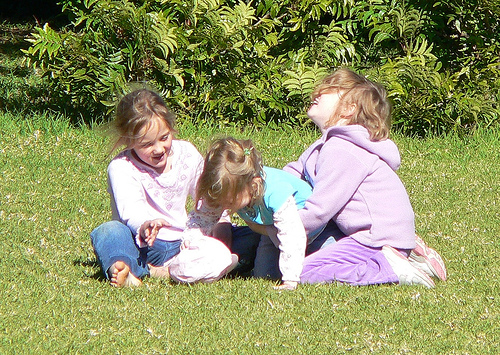

### TASK 2: Implement a tokenizer using pre-trained language models

Next, we'll preprocess text data by tokenizing it using Hugging Face's [AutoTokenizer](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#autotokenizer), specifically the `bert-base-cased` model. Since the vocabulary of `bert-base-cased` is significantly larger than that of our captions dataset, we'll create a wrapper class for `AutoTokenizer` to define custom token-to-vocabulary mappings.

In [ ]:
from transformers import AutoTokenizer
from tqdm import trange

class TokenizerWrapper:
    """Wraps AutoTokenizer with a custom vocabulary mapping."""

    def __init__(self, model_name="bert-base-cased"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
        # Initialize mappings with special tokens: [PAD] -> 0, [CLS] -> 1, [SEP] -> 2
        self.token_id_to_vocab_id = {0: 0, 101: 1, 102: 2}
        self.vocab_id_to_token_id = {0: 0, 1: 101, 2: 102}
        
        self.vocab_id = 3  # Start after special tokens
        self.padding_len = None

    def build_dictionary(self, captions: list[str]):
        """Builds vocabulary from a list of captions and sets padding length."""
        tokenized = self.tokenizer(captions, padding='longest').input_ids
        self.padding_len = len(tokenized[0])

        for tokens in tokenized:
            for token_id in tokens:
                if token_id not in self.token_id_to_vocab_id:
                    self.token_id_to_vocab_id[token_id] = self.vocab_id
                    self.vocab_id_to_token_id[self.vocab_id] = token_id
                    self.vocab_id += 1

    def get_vocab_size(self) -> int:
        """Returns the size of the custom vocabulary."""
        assert len(self.token_id_to_vocab_id) == len(self.vocab_id_to_token_id)
        return self.vocab_id

    def tokenize(self, text: str) -> list[int]:
        """Tokenizes text using custom vocabulary (requires build_dictionary first)."""
        assert self.padding_len is not None, "Call build_dictionary() before tokenizing."
        token_ids = self.tokenizer(text, padding='max_length', max_length=self.padding_len).input_ids
        return [self.token_id_to_vocab_id[token_id] for token_id in token_ids]

    def decode(self, vocab_ids: list[int]) -> str:
        """Decodes a list of custom vocab IDs into a string."""
        token_ids = [self.vocab_id_to_token_id[vocab_id] for vocab_id in vocab_ids]
        # Using `self.tokenizer.decode` to convert a list of token IDs back into a text string.
        text = self.tokenizer.decode(token_ids)
        return text.replace('[CLS] ', '').replace(' [SEP]', '').replace(' [PAD]', '')


In [22]:
# Build the dictionary for our tokenizer  
tokenizer_wrapper = TokenizerWrapper()
tokenizer_wrapper.build_dictionary(df["caption"].to_list())

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [23]:
# What's the size of our custom vocabulary
tokenizer_wrapper.get_vocab_size() 

7501

In [24]:
tokenizer_wrapper.tokenizer.vocab_size

28996

In [25]:
# let's try to tokenize the caption corresponding to the image we saw in the last task, 
# and decode the tokens back to the caption

caption_tokens = tokenizer_wrapper.tokenize(df.iloc[34396].caption)
decoeded_caption = tokenizer_wrapper.decode(caption_tokens)
print('Caption:', df.iloc[34396].caption)
print('Tokens:', caption_tokens)
print('Decoded caption:', decoeded_caption)

# Your Caption and the Decoded caption should match here. 

# your class should pass these two tests. feel free to explore the image features 
assert isinstance(caption_tokens, list)
assert isinstance(decoeded_caption, str)
assert len(caption_tokens) == tokenizer_wrapper.padding_len

Caption: Three children sit on the grass .
Tokens: [1, 405, 506, 294, 45, 27, 72, 18, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded caption: Three children sit on the grass.


<br><br>

### TASK 3: Data splitting and creating a Pytorch dataset

So far, we have implemented an image feature extractor to extract feature vectors from given images and a tokenizer to obtain encoded representations of captions. Now, let's prepare our data for both training and evaluating our models.

First, we'll split the data into training and testing subsets.

In [26]:
import pandas as pd
import numpy as np

def train_test_split_by_image(data_df, sample_size=None, train_ratio=0.8, seed=100):
    """
    Splits the dataframe into training and testing datasets based on unique images.
    
    Parameters:
        data_df (pandas.DataFrame): The dataset to split, containing at least 'image' and 'caption' columns.
        sample_size (int): The number of samples to consider. Useful during prototyping.
        train_ratio (float): The proportion of the dataset to allocate to the training set.
        seed (int): Seed for random number generator for reproducibility.

    Returns:
        train_df (pandas.DataFrame): Training dataset.
        test_df (pandas.DataFrame): Testing dataset.
    """
    np.random.seed(seed)
    unique_images = np.random.permutation(data_df['image'].unique())

    if sample_size:
        unique_images = unique_images[:sample_size]

    split_point = int(len(unique_images) * train_ratio)
    train_images, test_images = unique_images[:split_point], unique_images[split_point:]

    train_df = data_df[data_df['image'].isin(train_images)]
    test_df = data_df[data_df['image'].isin(test_images)]

    return train_df, test_df

In [27]:
# For prototyping 
train_df, test_df = train_test_split_by_image(df, sample_size = 100, train_ratio=0.8)
print(f'The number of rows in the training set is {train_df.shape[0]} and the number of unique images is {int(train_df.shape[0]/5)}')
print(f'The number of rows in the test set is {test_df.shape[0]} and the number of unique images is {int(test_df.shape[0]/5)}')
train_df.head()

The number of rows in the training set is 400 and the number of unique images is 80
The number of rows in the test set is 100 and the number of unique images is 20


image  \
295  1077546505_a4f6c4daa9.jpg   
296  1077546505_a4f6c4daa9.jpg   
297  1077546505_a4f6c4daa9.jpg   
298  1077546505_a4f6c4daa9.jpg   
299  1077546505_a4f6c4daa9.jpg   

                                                                                                                      caption  
295                                                                    A boy in blue shorts slides down a slide into a pool .  
296  A boy in blue swimming trunks slides down a yellow slide into a wading pool with inflatable toys floating in the water .  
297                                                                     A boy rides down a slide into a small backyard pool .  
298                                                              A boy sliding down a slide into a pool with colorful tubes .  
299                                        A child is falling off a slide onto colored balloons floating on a pool of water .

In [28]:
# # once you are confident about your model, use the entire data!!! 
train_df, test_df = train_test_split_by_image(df, train_ratio=0.8)
print(f'The number of rows in the training set is {train_df.shape[0]} and the number of unique images is {train_df.shape[0]/5}')
print(f'The number of rows in the test set is {test_df.shape[0]} and the number of unique images is {test_df.shape[0]/5}')
train_df.head()

The number of rows in the training set is 32360 and the number of unique images is 6472.0
The number of rows in the test set is 8095 and the number of unique images is 1619.0


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                                                    caption  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .  
2                          A little girl climbing into a wooden playhouse .  
3                      A little girl climbing the stairs to her playhouse .  
4                 A little girl in a pink dress going into a wooden cabin .

Now that we have train and test datasets, the next steps involve:

- Processing each image and caption in the training and testing sets.
- Creating a PyTorch dataset for efficient batch loading and processing.
  
We will first write a function called `build_data` to convert the data into a torch tensor, and then write a class called `PytorchDataset` to create a PyTorch dataset.
<br><br>

### 2.3: TASK 3
rubric={accuracy}

<div class="alert alert-info">
    
**Your tasks:**


1. Complete the `build_data` function:
    - Use the `feature_extractor` from Exercise 2.1 to obtain the image feature.
      
    - Use the `tokenizer_wrapper` from Exercise 2.2 to obtain numericalized representation of captions.
    - Convert the list of tokens into a torch tensor. Additionally, store the dimension (as a scalar, not a tuple) of the image features into `image_dim` variable below. Ensure that the dimension is dynamically retrieved rather than hard-coded.
  
<div>

<div class="alert alert-warning">

Solution_2_3
    
</div>

In [29]:
def build_data(data_df, tokenizer_wrapper, feature_extractor, image_folder):
    """
    Constructs a dataset list from provided image and caption data.

    This function processes each entry in a dataframe, extracts image features using a specified
    feature extractor, tokenizes captions using a tokenizer wrapper, and combines these elements into
    a list where each item is a dictionary containing image features and tokenized caption data.

    Parameters:
        data_df (pandas.DataFrame): A dataframe containing at least two columns: 'image' and 'caption'.
            - 'image' column contains filenames of images.
            - 'caption' column contains the corresponding captions for the images.
        tokenizer_wrapper (TokenizerWrapper): An object encapsulating a tokenizer that provides
            a method 'tokenize' to convert text captions into token ids.
        feature_extractor (Callable): A function or callable object that accepts an image object and
            returns a tensor representing extracted features from the image.
        image_folder (str): The path to the folder where images are stored. The path should not
            end with a slash. It is assumed that images are stored within an 'Images' subfolder.

    Returns:
        list: A list of dictionaries, where each dictionary has two keys:
            - 'image': a tensor containing features of the image.
            - 'token': a tensor of token ids derived from the caption.

    Example:
        Assuming 'data_df' has two columns 'image' and 'caption' where 'image' contains filenames:
        >>> data_df = pd.DataFrame({
        ...     'image': ['image1.jpg', 'image2.jpg'],
        ...     'caption': ['A cat on a mat.', 'A dog in the fog.']
        ... })
        >>> dataset = build_data(data_df, tokenizer_wrapper, feature_extractor, '/path/to/images')
        >>> print(dataset[0]['image'])  # Outputs the tensor of image features for 'image1.jpg'
        >>> print(dataset[0]['token'])  # Outputs the tensor of token ids for 'A cat on a mat.'
    """    

    dataset = []
    for i in trange(len(data_df)):
        row = data_df.iloc[i]
        image_path = f"{image_folder}/Images/{row.image}"
        image = PIL_Image.open(image_path)

        # TODO: Get image features 
        image_features = feature_extractor(image) # SOLUTION

        # TODO: Get caption tokens
        caption_tokens = torch.tensor(tokenizer_wrapper.tokenize(row.caption)) # SOLUTION
        dataset.append({'image': image_features, 'token': caption_tokens})
    return dataset
    

Let's create train and test datasets by calling `build_data` on train and test splits. 

In [30]:
train_data = build_data(train_df, tokenizer_wrapper, feature_extractor, image_folder)
test_data = build_data(test_df, tokenizer_wrapper, feature_extractor, image_folder)

100%|██████████| 8095/8095 [01:53<00:00, 71.43it/s]


In [31]:
# Get the dimension of the image feature
image_dim = train_data[0]['image'].shape[-1] # SOLUTION
vocab_size = tokenizer_wrapper.get_vocab_size()
print(f'Image feature dimension is {image_dim}. The vocab size is {vocab_size}.')

# your image_dim should pass this test
assert isinstance(image_dim, int)

Image feature dimension is 512. The vocab size is 7501.


Now let's buid our PyTorch dataset. 

In [32]:
class PytorchDataset:
    """
    A PyTorch-compatible dataset that returns:
    - the original token sequence,
    - image features,
    - and the target sequence (input shifted left with padding at the end).
    """

    def __init__(self, data, pad_vocab_id=0):
        self.data = data
        self.pad_token = torch.tensor([pad_vocab_id])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data[idx]['token']
        image = self.data[idx]['image']
        target = torch.cat([tokens[1:], self.pad_token])
        return tokens, image, target


In [33]:
train_dataset = PytorchDataset(train_data)
test_dataset = PytorchDataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [34]:
# Now let's get the first data from PytorchDataset
train_token, train_image, train_target = train_dataset[0]

# your dataset should pass these tests
assert train_token.shape == train_target.shape
assert torch.all(train_token[1:] == train_target[:-1]).item()

In [35]:
# Shape of the image features
train_image.shape

torch.Size([1, 512])

In [36]:
# Numericalized caption
train_token 

tensor([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11,  6, 12, 13, 14,  5, 15, 16, 17,
        18,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0])

In [37]:
# decoded caption
tokenizer_wrapper.decode(train_token.tolist()) 

'A child in a pink dress is climbing up a set of stairs in an entry way.'

In [38]:
# the target of the train_token (i.e., training example) 
train_target

tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11,  6, 12, 13, 14,  5, 15, 16, 17, 18,
         2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0])

In [39]:
# decoded caption
tokenizer_wrapper.decode(train_target.tolist()) 

'A child in a pink dress is climbing up a set of stairs in an entry way.'

The decoded caption is the same for input and target because the special token [CLS] with token ID 1 is **not** displayed in the decoded caption. 

<br><br>

In [40]:
# Now let's get a batch of data from DataLoader
train_text, train_image, train_target = next(iter(train_dataloader))
train_text = train_text.to(device)
train_image = train_image.to(device)

assert train_image.ndim == 3
assert train_text.ndim == 2

In [41]:
train_text.shape # batch_size, max_len

torch.Size([64, 43])

In [42]:
train_image.shape

torch.Size([64, 1, 512])

In [43]:
train_target.shape # batch_size, max_len

torch.Size([64, 43])

<br><br>

### TASK 4: Implement your own image caption model using PyTorch
<hr>

Now we are ready to define our own transformer model tailored for image captioning! 

![](img/task4.png)


The diagram above shows how image features and token sequences are processed in a caption generation model.

- Image features are projected into the model's embedding space using `self.image_embedding`, then reshaped to act as the decoder's memory.

- Token IDs are embedded using `self.text_embedding` and enriched with positional information using `self.pos_encoding` (defined in `utils.py`).

- These two inputs are passed to the TransformerDecoder, which produces context-aware token representations.

- The decoder output is passed through a `linear_layer` to generate vocabulary logits, followed by a softmax to produce token probabilities.

- During inference, a token is sampled from this distribution and used to generate the next word.

![](img/transformer-decoder.png)

<div class="alert alert-info">
    
### 2.4: TASK 4

rubric={accuracy}

**Your tasks:**

1. **Implement `ImageCaptionModel.forward`**:   
    - (a) Obtain the image embedding by passing the image feature through the corresponding layer.
      
        - **Hint:** Permute the dimensions to reshape the encoded image feature to have the shape (sequence length, batch size, d_model). Note that in this caption generation setup, we are assuming that the image features represent a single "token", so the sequence length for the image is 1.
          
    - (b) Process the token IDs to retrieve the token embedding.
      
        - **Hint:** Scale the caption embedding by `math.sqrt(self.embedding_size)`, similar to how we did it in Exercise 1. 
          
        - **Hint:** Add positional encoding to the sequences.
          
        - **Hint:** Again, permute the dimensions to ensure the encoded captions have the shape (sequence length, batch size, d_model).      
    - (c) Pass all variables (image embeddings, caption embeddings, and masks) to the transformer model and obtain the output from the final linear layer.
  
</div>

<div class="alert alert-warning">

Solution_2_4
    
</div>

In [44]:
class ImageCaptionModel(nn.Module):
    def __init__(self, d_model, n_heads, num_layers, image_dim, vocab_size, device, dropout=0.1):
        """
        Initialize the ImageCaptionModel which uses a transformer decoder architecture
        for generating image captions.

        Parameters:
            d_model (int): The number of expected features in the encoder/decoder inputs.
            n_heads (int): The number of heads in the multiheadattention models.
            num_layers (int): The number of sub-decoder-layers in the transformer.
            image_dim (int): The dimensionality of the input image features.
            vocab_size (int): The size of the vocabulary.
            device (torch.device): The device on which the model will be trained.
            dropout (float): The dropout value used in PositionalEncoding and TransformerDecoderLayer.
        """        
        super(ImageCaptionModel, self).__init__()
        self.d_model = d_model
        self.device = device
        # Positional Encoding to add position information to input embeddings
        self.pos_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)

        # Here is our transformer architecture
        
        # Transformer Decoder to generate captions from image features and text inputs
        self.TransformerDecoder = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout), 
            num_layers=num_layers
        )

        # Linear layer to convert image features to a dimensionality that matches the model's
        self.image_embedding = nn.Linear(image_dim , d_model)

        # Embedding layer for converting input text tokens into vectors
        self.text_embedding = nn.Embedding(vocab_size , d_model)

        # Final linear layer to map the output of the transformer decoder to vocabulary size        
        self.linear_layer = nn.Linear(d_model, vocab_size)

        # Initialize the weights of the model
        self.init_weights()
        
    def init_weights(self):
        """
        Initialize weights of the model to small random values.
        """
        initrange = 0.1
        self.text_embedding.weight.data.uniform_(-initrange, initrange)
        self.image_embedding.weight.data.uniform_(-initrange, initrange)
        self.linear_layer.bias.data.zero_()
        self.linear_layer.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, image, text):
        """
        Defines the forward pass of the model.

        Parameters:
            image (Tensor): The tensor containing image features.
            text (Tensor): The tensor containing input text tokens.

        Returns:
            Tensor: The output tensor containing the logit scores for each vocabulary token.
        """        
        # BEGIN SOLUTION
        
        # Convert image features to match the dimensionality of the model
        encoded_image = self.image_embedding(image)
        encoded_image = encoded_image.permute(1,0,2)

        # Convert text tokens into embeddings and apply positional encoding
        encoded_text = self.text_embedding(text) * math.sqrt(self.d_model)        
        encoded_text = encoded_text.permute(1,0,2)        
        encoded_text = self.pos_encoding(encoded_text)
        # END SOLUTION 
        
        # Get the length of the sequences to be decoeded. This is needed to generate the causal masks
        seq_len = encoded_text.size(0)  # SOLUTION

        # Generate a causal mask to prevent the model from attending to future tokens
        causal_mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
        causal_mask = causal_mask.float().masked_fill(causal_mask == 0, float('-inf')).masked_fill(causal_mask == 1, float(0.0))
        causal_mask = causal_mask.to(self.device)

        # Process through the transformer decoder
        transformer_output = self.TransformerDecoder(tgt=encoded_text, memory=encoded_image, tgt_mask=causal_mask)  # SOLUTION

        # Apply the final linear layer to produce predictions for each token
        final_layer_output = self.linear_layer(transformer_output)  # SOLUTION
        return final_layer_output

In [45]:
# Now let's try your model. 
# Define the hyperparameters and initalize the model. Feel free to change these hyperparameters. 
d_model = 256 
n_heads = 4
num_layers = 8
model = ImageCaptionModel(d_model=d_model, n_heads=n_heads, num_layers=num_layers, image_dim=image_dim, vocab_size=vocab_size, device=device).to(device)

In [46]:
# pass inputs to your model
output = model(train_image, train_text)

# output should pass the test
assert output.shape == (train_text.shape[1], train_text.shape[0], vocab_size)

<br><br>

<div class="alert alert-info">
    
### 2.5 TASK 5: Implement the training loop
rubric={accuracy}

The next step is to train our `ImageCaptionModel` using the dataset you've prepared. We are defining the optimizer and the loss function below. 

**Your Tasks:**

1. Write code to compute the loss for the sampled training batch:
   - **Hint:** Use the criterion to calculate the loss for the training batch.
     
   - **Hint:** You might need to permute the dimensions of the model output to match the expected input shape for `torch.nn.CrossEntropyLoss`, which is (batch size, vocab size, sequence length). Refer to the [PyTorch documentation on `CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) for more details.
     
2. Similarly, write code to calculate the loss for the testing batch using the criterion.
   
3. Train your model. Consider saving it for further use.

</div>

In [47]:
# Define the optimizer and the loss function. Feel free to change the hyperparameters. 

num_epoch = 30
clip_norm = 1.0
lr = 5e-5

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0) # Ignore the padding index

<div class="alert alert-warning">

Solution_2_5
    
</div>

In [48]:
def trainer(model, criterion, optimizer, train_dataloader, test_dataloader, epochs=5, patience=5):
    """
    Trains and evaluates a model using the specified dataloaders, optimizer, and loss criterion with early stopping.
    """    
    train_losses = []
    test_losses = []
    consec_increases = 0        
    
    for epoch in range(epochs):
        sum_train_loss = 0
        sum_test_loss = 0
        num_train_loss = 0        
        num_test_loss = 0

        # Set model to training mode
        model.train()

        for train_text, train_image, target_seq in train_dataloader:

            train_text = train_text.to(device)
            train_image = train_image.to(device)
            target_seq = target_seq.to(device)

            # Forward pass
            output = model(train_image, train_text)  # SOLUTION
            output = output.permute(1, 2, 0)  # SOLUTION
            train_loss = criterion(output, target_seq)  # SOLUTION

            # Backward pass 
            optimizer.zero_grad()        
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()

            # Book keeping 
            sum_train_loss += torch.sum(train_loss).detach().item()
            num_train_loss += 1 

        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for test_text, test_image, target_seq in test_dataloader:
                test_text = test_text.to(device)
                test_image = test_image.to(device)
                target_seq = target_seq.to(device)

                # Forward pass
                output = model(test_image, test_text)  # SOLUTION
                output = output.permute(1, 2, 0)  # SOLUTION
                test_loss = criterion(output, target_seq) # SOLUTION
                
                # Book keeping 
                sum_test_loss += torch.sum(test_loss).detach().item()
                num_test_loss += 1

        # Calculate and store average losses
        avg_train_loss = sum_train_loss / num_train_loss
        avg_test_loss = sum_test_loss / num_test_loss
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.2f}, Test Loss {avg_test_loss:.2f}")

        # Early stopping
        if epoch > 0 and test_losses[-1] > test_losses[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - test loss increased for {consec_increases} consecutive epochs!")
            break
            
    return train_losses, test_losses
        

In [49]:
train_losses, test_losses = trainer(model, criterion, optimizer,train_dataloader, test_dataloader, epochs= num_epoch)

Epoch 1: Train Loss 5.41, Test Loss 4.39
Epoch 5: Train Loss 3.42, Test Loss 3.41
Epoch 6: Train Loss 3.28, Test Loss 3.30
Epoch 7: Train Loss 3.15, Test Loss 3.22
Epoch 8: Train Loss 3.05, Test Loss 3.17
Epoch 9: Train Loss 2.96, Test Loss 3.11
Epoch 10: Train Loss 2.88, Test Loss 3.06
Epoch 11: Train Loss 2.80, Test Loss 3.03
Epoch 12: Train Loss 2.74, Test Loss 2.99
Epoch 13: Train Loss 2.67, Test Loss 2.97
Epoch 14: Train Loss 2.62, Test Loss 2.95
Epoch 15: Train Loss 2.56, Test Loss 2.93
Epoch 16: Train Loss 2.51, Test Loss 2.91
Epoch 17: Train Loss 2.46, Test Loss 2.90
Epoch 18: Train Loss 2.41, Test Loss 2.89
Epoch 22: Train Loss 2.24, Test Loss 2.87
Epoch 23: Train Loss 2.20, Test Loss 2.86
Epoch 24: Train Loss 2.16, Test Loss 2.87
Epoch 25: Train Loss 2.12, Test Loss 2.87
Epoch 26: Train Loss 2.08, Test Loss 2.87
Epoch 27: Train Loss 2.04, Test Loss 2.87
Epoch 28: Train Loss 2.01, Test Loss 2.88
Epoch 29: Train Loss 1.97, Test Loss 2.88
Epoch 30: Train Loss 1.94, Test Loss 2.8

<br><br>

<div class="alert alert-info">
    
## 2.6 TASK 6: Generate captions using the trained model
rubric={accuracy}

Now that we have trained our model, the moment of truth has arrived! The final task is generating captions using `ImageCaptionModel`.

**Your Tasks:**

1. We have already implemented the `generate_caption function`, which generates a caption for a given image using the trained model. Use this function to **generate captions for several images in the test set**.
2. Show the original and generated captions along with the corresponding image for at least five images from the test set.

**Troubleshooting Tips:**
- If your model generates nonsensical captions, consider adjusting the hyperparameters. For instance, you might need to use more data or run it for more epochs. However, do not expect very high-quality captions, especially if you are using a small subset for training. The primary objective of this exercise is to familiarize yourself with the process of developing your own transformer-based model. If you have a working model, that goal is achieved, and we consider it a success!

</div>

In [50]:
# This function is already implemented for you. Do not change this function.

def get_test_data(index): 
    """
    Retrieve the text and image data from the test dataset at the specified index.

    Parameters:
        index (int): The index of the test dataset from which to fetch the data.

    Returns:
        tuple: A tuple containing:
            - test_text (Tensor): The tensor representing the caption.
            - test_image (Tensor): The tensor representing the image.
    """    
    test_text, test_image, target_seq = test_dataset[index]
    return test_text, test_image
    
def generate_caption(model, image, device, max_caption_length=100, start_vocab=1, end_vocab=2):
    """
    Generates a caption for an image using the specified model and device.

    Parameters:
        model (torch.nn.Module): The trained model used for generating captions.
        image (torch.Tensor): The image tensor for which to generate the caption.
        device (torch.device): The device (e.g., CPU or GPU) to which tensors will be sent for model execution.
        max_caption_length (int, optional): The maximum length of the generated caption. Defaults to 100.
        start_vocab (int, optional): The vocabulary index used to signify the start of a caption. Defaults to 1.
        end_vocab (int, optional): The vocabulary index used to signify the end of a caption. Defaults to 2.
        
    Returns:
        numpy.ndarray: An array containing the sequence of vocabulary indices representing the generated caption.
        
    """    
    image = torch.unsqueeze(image, dim=0).to(device)
    context = torch.tensor([[start_vocab]]).to(device)
    for _ in range(max_caption_length):
        logits = model(image, context)[-1]
        probabilities = torch.softmax(logits, dim=-1).flatten(start_dim=1)
        next_vocab = torch.multinomial(probabilities, num_samples=1)
        context = torch.cat([context, next_vocab], dim=1)
        if next_vocab.item() == end_vocab:
            break
    return context.cpu().numpy().flatten()

<div class="alert alert-warning">

Solution_2_6
    
</div>

In [51]:
# BEGIN SOLUTION
import random 

random.seed(10)

def display_img_captions(image_folder, n_samples = 5, indices=None):
    
    # Set a fixed size for images
    desired_size = (200, 200)

    # If no specific indices are provided, select random samples
    if indices == None:
        indices = random.sample(range(test_df.shape[0]), n_samples)
        print(indices)
    
    for index in indices: 
        test_text, test_image = get_test_data(index=index)
        generated_vocab = generate_caption(model, test_image, device, max_caption_length=100)
        generated_caption = tokenizer_wrapper.decode(generated_vocab)
        gold_caption = tokenizer_wrapper.decode(test_text.numpy())

        # Load and prepare the image
        image_path = '{}/Images/{}'.format(image_folder, test_df.iloc[index]['image'])
        image = PIL_Image.open(image_path)
        img = image.resize(desired_size)
        
        # Display the image
        plt.figure(figsize=(5, 5))  # Create a new figure for each image
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.title(f"Generated: {generated_caption}\nActual: {gold_caption}")
        plt.show()
        
        # print('Generated: ', generated_caption)
        # print('Actual: ', gold_caption)
        print('\n\n')
# END SOLUTION        

In [52]:
# BEGIN SOLUTION
test_df.shape
# END SOLUTION

(8095, 2)

[4680, 266, 3513, 3953, 4735, 121, 1688, 3789, 6662, 4024]


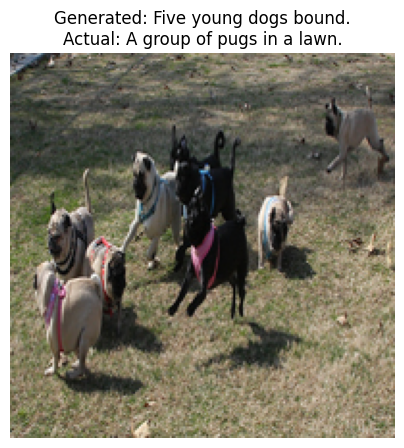

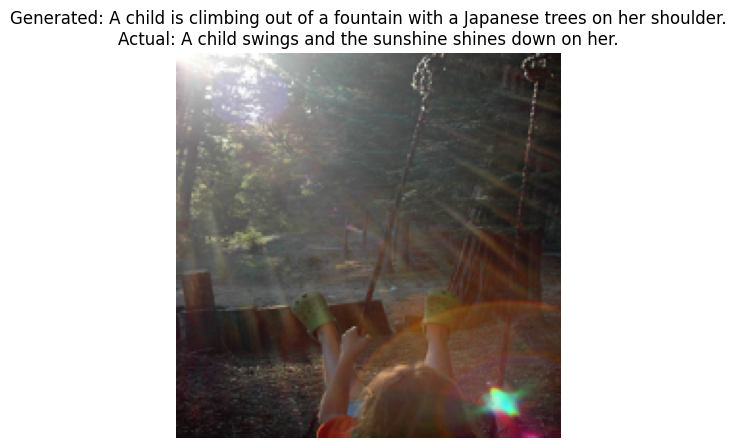

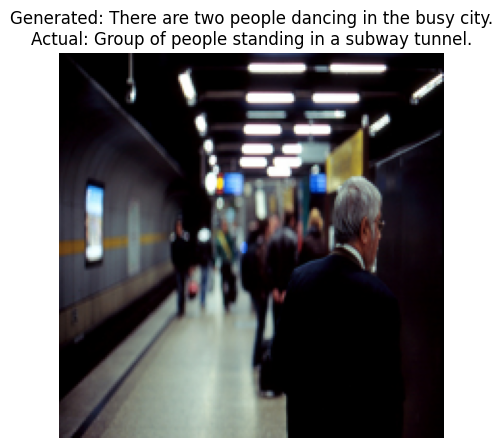

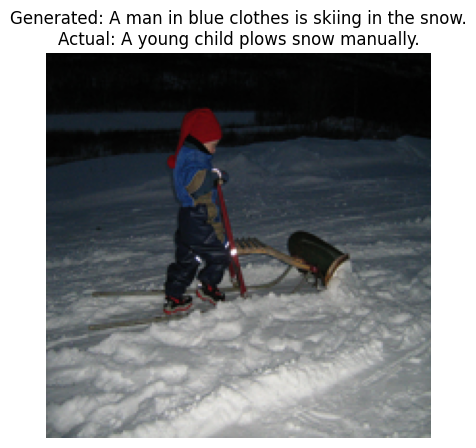

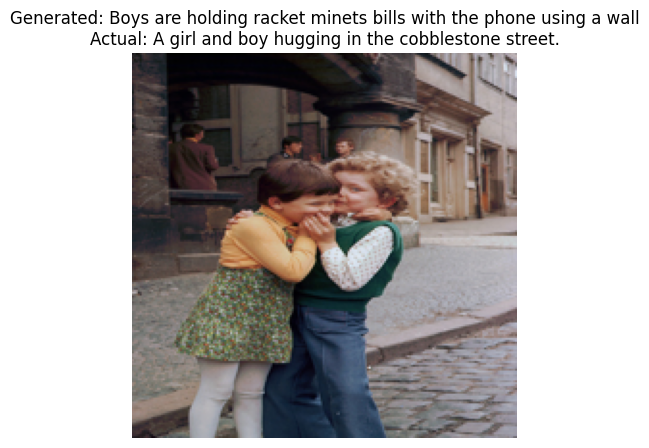

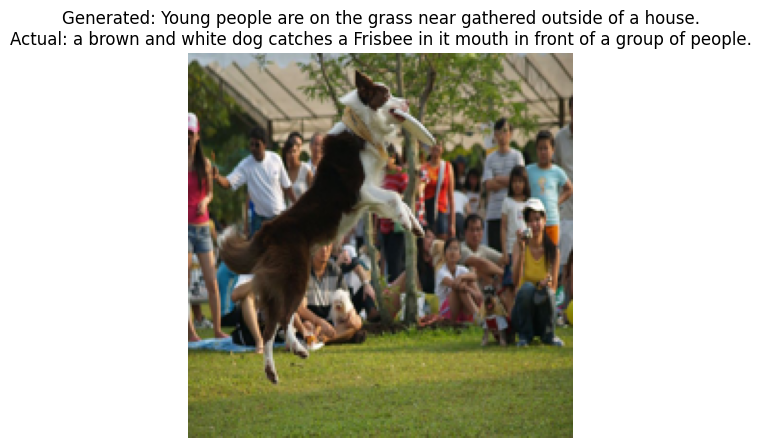

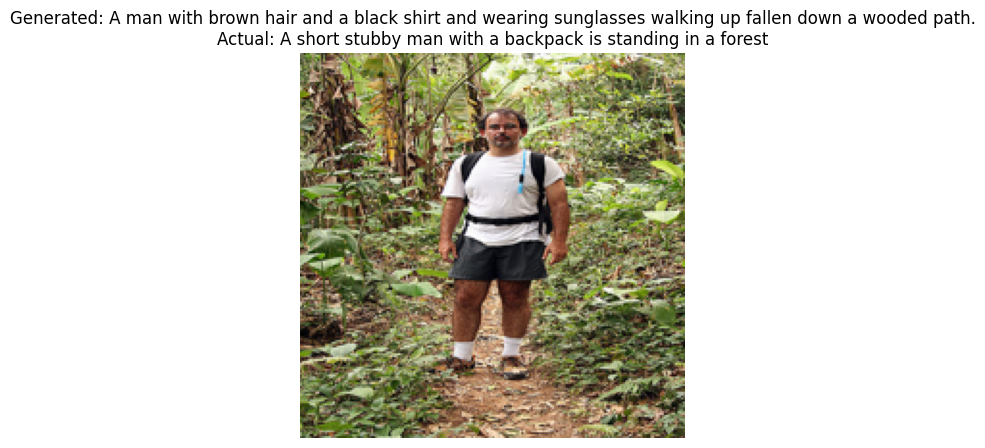

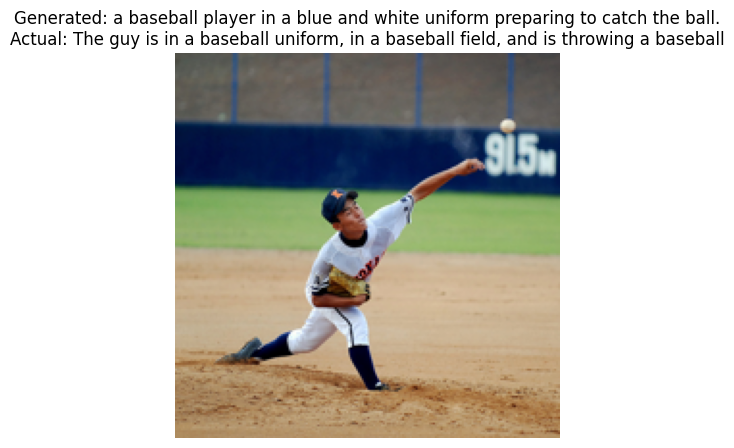

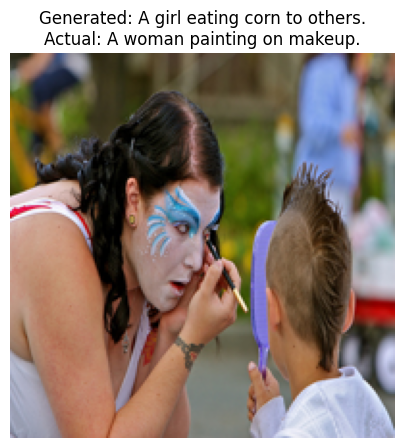

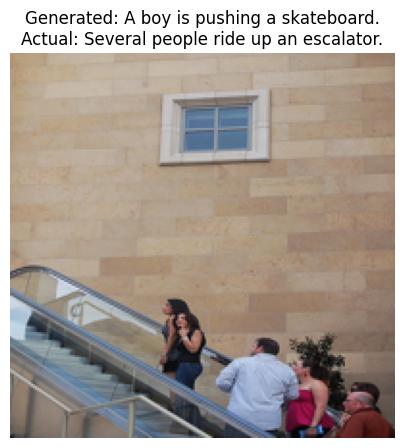

In [53]:
# BEGIN SOLUTION
display_img_captions(image_folder, n_samples = 10)
# END SOLUTION

<br><br>

<div class="alert alert-info">
    
## 2.7 Discussion
rubric={reasoning}

**Your Tasks:**

1. Comment on the quality of the generated captions. To what extent is the model able to identify key actions and objects in the images? 
2. Discuss potential modifications in model architecture, training dataset, or hyperparameter tuning to improve performance of your image captioning model.
</div>

<div class="alert alert-warning">

Solution_2_7
    
</div>

TBA

<br><br><br><br>

<br><br>

<div class="alert alert-info">
    
## Exercise 3: Your takeaway and reflections
rubric={reasoning}


**Your tasks:**

- Reflect on your experience in this course and across the machine learning courses in the program. What are your three biggest takeaways or insights?

- Think about the course content across these ML courses. Which topics did you find most useful? Which were least useful? Are there any topics you wish had been covered but weren't? (I know we need to add more topics covering LLM applications.)

- Many of you may have used large language models (LLMs) like ChatGPT during your learning. How do you think LLMs could be meaningfully and effectively integrated into our machine learning curriculum?

> Please be thoughtful, thorough, and specific in your responses. We greatly value your insights.

<div>

<div class="alert alert-warning">

Solution_3
    
</div>

<br><br><br><br>

Since this is your final lab and Exercise 2 was quite challenging, we will not have our "Food for thought" section in this lab. 

Before submitting your assignment, please make sure you have followed all the instructions in the Submission Instructions section at the top. 

That's it! Congrats on finishing the last lab of your last machine learning course! Woohoo!! 🎉

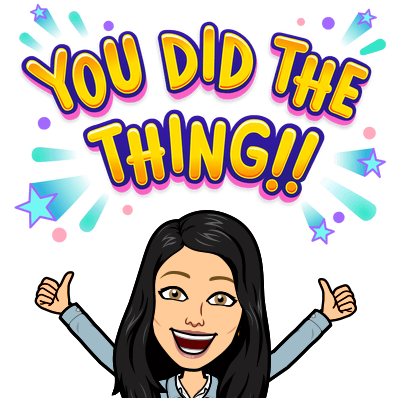

In [1]:
from IPython.display import Image

Image("img/eva-congrats.png")